# Siamese Neural Network

In [ ]:
import io
import os
import numpy as np
import numpy.random as rng

from PIL import Image

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda, Dropout
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
%matplotlib inline

## Load Products Dataset

In [ ]:
import os
import imageio
import shutil

from zipfile import ZipFile

cur_dir = os.getcwd()

In [ ]:
shutil.rmtree('./train', ignore_errors=True)
shutil.rmtree('./test', ignore_errors=True)
shutil.rmtree('./validation', ignore_errors=True)
shutil.rmtree('./sample_data', ignore_errors=True)

In [ ]:
data_folder_path = os.path.join(os.getcwd(), "drive/MyDrive/TCC/train_data")
print(data_folder_path)

train_zip_path = os.path.join(data_folder_path, "train.zip")
print(train_zip_path)

test_zip_path = os.path.join(data_folder_path, "test.zip")
print(test_zip_path)

validation_zip_path = os.path.join(data_folder_path, "validation.zip")
print(validation_zip_path)

/content/drive/MyDrive/TCC/train_data
/content/drive/MyDrive/TCC/train_data/train.zip
/content/drive/MyDrive/TCC/train_data/test.zip
/content/drive/MyDrive/TCC/train_data/validation.zip


In [ ]:
with ZipFile(train_zip_path, 'r') as zip:
    zip.extractall()
    print('Unzipped train.zip')

with ZipFile(test_zip_path, 'r') as zip:
    zip.extractall()
    print('Unzipped test.zip')

with ZipFile(validation_zip_path, 'r') as zip:
    zip.extractall()
    print('Unzipped validation.zip')

Unzipped train.zip
Unzipped test.zip
Unzipped validation.zip


In [ ]:
def loadData(s = "train"):
  if s == "train":
    data_path = os.path.join(cur_dir, "train")
  elif s == "test":
    data_path = os.path.join(cur_dir, "test")
  else:
    data_path = os.path.join(cur_dir, "validation")

  x = []
  y = []
  classes = []

  for folder in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder)

    class_num = len(classes)
    classes.append(folder)
    images = []
    for filename in os.listdir(folder_path):
      image_path = os.path.join(folder_path, filename)
      image = imageio.imread(image_path)
      images.append((image).astype(np.float32) / 255.0)

    x.append(np.stack(images))
    y.append(class_num)

  return np.stack(x), np.stack(y), classes

In [ ]:
x_train, y_train, class_names = loadData("train")
x_test, y_test, test_class_names = loadData("test")
x_validation, y_validation, validation_class_names = loadData("validation")
print("Train:\t\t", x_train.shape)
print("Test:\t\t", x_test.shape)
print("Validation:\t", x_validation.shape)

Train:		 (11, 2280, 128, 128, 3)
Test:		 (11, 329, 128, 128, 3)
Validation:	 (11, 839, 128, 128, 3)


In [ ]:
x_train = np.append(x_train, x_validation, axis=1)

In [ ]:
x_train.shape

(11, 3119, 128, 128, 3)

In [ ]:
classes = np.arange(len(class_names)).tolist()
print("Indexes:\t", classes)
print("Train:\t\t", class_names)
print("Test:\t\t", test_class_names)
print("Validation:\t", validation_class_names)

Indexes:	 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Train:		 ['pepsi-garrafa', 'negresco', 'coca-lata', 'guarana-lata', 'feijao', 'arroz', 'coca-garrafa', 'laranja', 'milho-lata', 'maca', 'acucar']
Test:		 ['pepsi-garrafa', 'negresco', 'coca-lata', 'guarana-lata', 'feijao', 'arroz', 'coca-garrafa', 'laranja', 'milho-lata', 'maca', 'acucar']
Validation:	 ['pepsi-garrafa', 'negresco', 'coca-lata', 'guarana-lata', 'feijao', 'arroz', 'coca-garrafa', 'laranja', 'milho-lata', 'maca', 'acucar']


'guarana-lata'

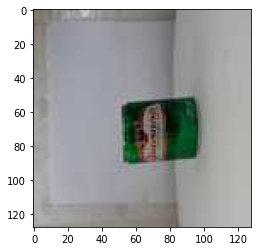

In [ ]:
index = 3
image_idx = 10
plt.imshow(x_train[index, image_idx])
class_names[y_train[index]]

## Load Cifar 10 Dataset

In [ ]:
from tensorflow.keras.datasets import cifar10

In [ ]:
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
(x_train_master, y_train_master), (x_test_master, y_test_master) = cifar10.load_data()

In [ ]:
x_train_master = x_train_master / 255.0
x_test_master = x_test_master / 255.0

In [ ]:
def loadData(x, y, classes):
  e = []
  for c in range(len(classes)):
    c_idx = [i for i, v in enumerate(y) if v[0] == c]

    r = []
    for se in x[c_idx]:
      i = Image.fromarray(np.uint8(se))
      i = i.resize((150, 150))
      i = np.array(i)
      r.append(i)

    e.append(np.stack(r))

  return np.stack(e)

In [ ]:
x_train = loadData(x_train_master, y_train_master, class_names)
x_test = loadData(x_test_master, y_test_master, class_names)

In [ ]:
print(x_train.shape)
print(x_test.shape)

In [ ]:
x_train = x_train / 255.0
x_test = x_test / 255.0

In [ ]:
index = 0
plt.imshow(x_train_master[index])
print(y_train_master[index, 0])
class_names[y_train_master[index, 0]]

In [ ]:
index = 4
example = 3
plt.imshow(x_train[index, example])
class_names[index]

In [ ]:
(_, _, w, h, c) = x_train.shape
input_shape = (w, h, c)
print(input_shape)

## Load Stanford Online Product Dataset

In [ ]:
import tensorflow_datasets as tfds

In [ ]:
ds = tfds.load('stanford_online_products', split='train')

In [ ]:
def convertData(ds):
  x = []
  y = []
  classes = {}

  for e in ds.take(-1):
    image = e["image"].numpy()
    label = "{}".format(e["class_id"].numpy())

    image = Image.fromarray(np.uint8(image))
    image = image.resize((150, 150))
    image = np.array(image)

    x.append(image)
    y.append(label)

    if not label in classes.keys():
      classes[label] = 1
    else:
      classes[label] += 1

  return np.array(x), y, classes

In [ ]:
x_train_master, y_train_master, c_train_master = convertData(ds)
class_names = list(c_train_master.keys())

In [ ]:
def getMinExamplesPerClass(classes):
  min_value = 1000

  for k in c_train_master.keys():
    if c_train_master[k] < min_value:
      min_value = c_train_master[k]

  return min_value

In [ ]:
def loadData(x, y, classes):
  max = getMinExamplesPerClass(classes)
  e = []
  for c in range(len(classes.keys())):
    c_idx = [i for i, v in enumerate(y) if v == "{}".format(c)]
    c_idx = rng.choice(c_idx, max, replace=False)
    e.append(np.stack(x[c_idx]))

  return np.stack(e)

In [ ]:
x_train = loadData(x_train_master, y_train_master, c_train_master)

In [ ]:
index = 4
plt.imshow(x_train_master[index])
class_names[int(y_train_master[index])]

## Load Siamese Model

In [ ]:
(_, _, w, h, c) = x_train.shape
input_shape = (w, h, c)
input_shape

(128, 128, 3)

In [ ]:
def initialize_weights(shape, dtype=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

In [ ]:
def initialize_bias(shape, dtype=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

In [ ]:
def get_embedding_model(input_shape):
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', 
                     kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(Conv2D(64, (10,10), activation='relu', 
                     kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (7,7), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Dropout(0.2))
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid', kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias))

    return model

In [ ]:
embedding_model = get_embedding_model(input_shape)
embedding_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_8 (Sequential)    (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 119, 119, 64)      19264     
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 110, 110, 64)      409664    
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 55, 55, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 49, 49, 128)       401536    
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 24, 24, 128)      

In [ ]:
def get_siamese_model(input_shape):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = get_embedding_model(input_shape)
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1, activation = 'sigmoid')(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs = [left_input, right_input], outputs = prediction)
    
    # return the model
    return siamese_net

In [ ]:
model = get_siamese_model(input_shape)
optimizer = Adam(learning_rate= 0.00006)
model.compile(loss="binary_crossentropy",optimizer=optimizer, metrics=["accuracy"])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
sequential_9 (Sequential)       (None, 4096)         53001600    input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 4096)         0           sequential_9[0][0]         

In [ ]:
model = tf.keras.models.load_model("model.h5")

## Train Model

In [ ]:
def get_batch(batch_size, s="train"):
    """Create batch of n pairs, half same class, half different class"""
    if s == 'train':
        X = x_train
    else:
        X = x_test

    n_classes, n_examples, w, h, c = X.shape
    
    # randomly sample several classes to use in the batch
    categories = rng.choice(n_classes, size=(batch_size,))

    # initialize 2 empty arrays for the input image batch
    pairs = [np.zeros((batch_size, h, w, c)) for i in range(2)]

    # initialize vector for the targets
    targets = np.zeros((batch_size,))

    # make one half of it '1's, so 2nd half of batch has same class
    targets[batch_size//2:] = 1

    for i in range(batch_size):
      category = categories[i]

      idx_1 = rng.randint(0, n_examples)
      pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, c)

      # pick images of same class for 1st half, different for 2nd
      if i >= batch_size // 2:
          category_2 = category  
      else: 
          # add a random number to the category modulo n classes to ensure 2nd image has a different category
          category_2 = (category + rng.randint(1, n_classes)) % n_classes
        
      idx_2 = rng.randint(0, n_examples)
      pairs[1][i,:,:,:] = X[category_2, idx_2].reshape(w, h, c)

    return pairs, targets   

In [ ]:
def generate(batch_size, s="train"):
    """a generator for batches, so model.fit_generator can be used. """
    while True:
        pairs, targets = get_batch(batch_size, s)
        yield (pairs, targets)

In [ ]:
batch_size = 128
epochs = 20
steps_per_epoch = 150

In [ ]:
history = model.fit(generate(batch_size), validation_data=(get_batch(batch_size, s="test")), epochs=epochs, steps_per_epoch=steps_per_epoch, verbose=1)

Epoch 1/20
150/150 [==============================] - 92s 611ms/step - loss: 3.1890 - accuracy: 0.4987 - val_loss: 2.4077 - val_accuracy: 0.5000
Epoch 2/20
150/150 [==============================] - 92s 613ms/step - loss: 1.9605 - accuracy: 0.4960 - val_loss: 1.6073 - val_accuracy: 0.4766
Epoch 3/20
150/150 [==============================] - 95s 630ms/step - loss: 1.1735 - accuracy: 0.7767 - val_loss: 1.2006 - val_accuracy: 0.6094
Epoch 4/20
150/150 [==============================] - 95s 631ms/step - loss: 0.8441 - accuracy: 0.8231 - val_loss: 1.0623 - val_accuracy: 0.6172
Epoch 5/20
150/150 [==============================] - 95s 632ms/step - loss: 0.6635 - accuracy: 0.8450 - val_loss: 0.9874 - val_accuracy: 0.6094
Epoch 6/20
150/150 [==============================] - 95s 631ms/step - loss: 0.5607 - accuracy: 0.8574 - val_loss: 0.9126 - val_accuracy: 0.6250
Epoch 7/20
150/150 [==============================] - 95s 630ms/step - loss: 0.4766 - accuracy: 0.8774 - val_loss: 0.8090 - val_ac

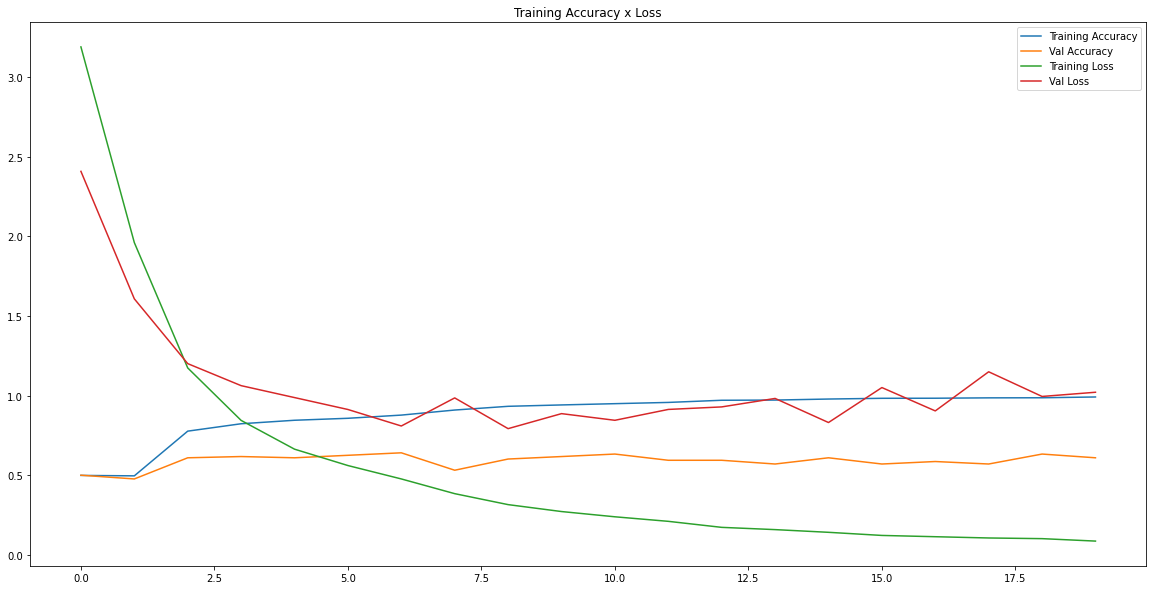

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 10))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend(loc='best')
plt.title('Training Accuracy x Loss')
plt.show()

## Validate Model

In [ ]:
def generate_pairs(image, s="val", expected_class=None):
  if s == 'train':
    X = x_train
  else:
    X = x_test

  n_classes, n_examples, w, h, c = X.shape

  pairs=[np.zeros((n_classes, w, h, c)) for i in range(2)]
  targets = np.zeros(n_classes)

  for i in range(0, n_classes):
    idx = rng.randint(0, n_examples)
    img = X[i, idx]

    pairs[0][i,:,:,:] = image.reshape(w, h, c)
    pairs[1][i,:,:,:] = img.reshape(w, h, c)

    if expected_class is not None:
      targets[i] = 1 if expected_class == i else 0

  if expected_class != None:
    return pairs, targets

  return pairs

In [ ]:
test_class_names

['pepsi-garrafa',
 'negresco',
 'coca-lata',
 'guarana-lata',
 'feijao',
 'arroz',
 'coca-garrafa',
 'laranja',
 'milho-lata',
 'maca',
 'acucar']

In [ ]:
x_test.shape

(11, 329, 128, 128, 3)

In [ ]:
y_train

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

Expected class: 2 - coca-lata


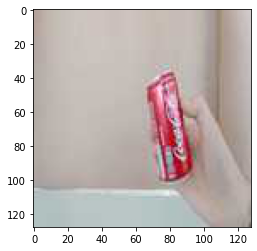

In [ ]:
index = 2
img_idx = 3
expected_class = y_test[index]
query_image = x_test[index, img_idx]

plt.imshow(query_image)
print("Expected class: {} - {}".format(expected_class, class_names[expected_class]))

In [ ]:
pairs, targets = generate_pairs(query_image, expected_class=expected_class)
probs = model.predict(pairs)
idx = np.argmax(probs)

print("Predicted image as {}".format(class_names[idx]))
print("Expected prediction as {}".format(class_names[expected_class]))

Predicted image as milho-lata
Expected prediction as coca-lata


In [ ]:
k = 100
n_correct = 0
for i in range(k):
  pairs, targets = generate_pairs(query_image, expected_class=expected_class)
  probs = model.predict(pairs)

  if np.argmax(probs) == np.argmax(targets):
    n_correct += 1

percent = (100 * n_correct / k)
print("Acurracy: {}%".format(percent))

Acurracy: 1.0%


In [ ]:
pairs=[np.zeros((2, 128, 128, 3)) for i in range(2)]
pairs[0][0,:,:,:] = x_test[0, 0]
pairs[1][0,:,:,:] = x_test[0, 0]
pairs[0][1,:,:,:] = x_test[0, 0]
pairs[1][1,:,:,:] = x_test[0, 1]
model.predict(pairs)

array([[0.51275826],
       [0.3239513 ]], dtype=float32)

## Save Model

In [ ]:
save_model_path = os.path.join(data_folder_path, "siamese/model.h5")
save_model_weights_path = os.path.join(data_folder_path, "siamese/model.weights.h5")

In [ ]:
model.save(save_model_path)
model.save_weights(save_model_weights_path)

# Triplet Loss Siamese Neural Network

In [ ]:
!pip install umap-learn

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
import umap
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *

tf.__version__

## Load Cifar 10 Dataset

In [ ]:
from tensorflow.keras.datasets import cifar10

In [ ]:
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [ ]:
print(x_train.shape)
print(x_test.shape)

In [ ]:
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

## Load Products Dataset

In [ ]:
import os
import imageio
import shutil

from zipfile import ZipFile

cur_dir = os.getcwd()

In [ ]:
shutil.rmtree('./train', ignore_errors=True)
shutil.rmtree('./test', ignore_errors=True)
shutil.rmtree('./validation', ignore_errors=True)
shutil.rmtree('./sample_data', ignore_errors=True)

In [ ]:
data_folder_path = os.path.join(os.getcwd(), "drive/MyDrive/TCC/train_data")
print(data_folder_path)

train_zip_path = os.path.join(data_folder_path, "train.zip")
print(train_zip_path)

test_zip_path = os.path.join(data_folder_path, "test.zip")
print(test_zip_path)

validation_zip_path = os.path.join(data_folder_path, "validation.zip")
print(validation_zip_path)

In [ ]:
with ZipFile(train_zip_path, 'r') as zip:
    zip.extractall()
    print('Unzipped train.zip')

with ZipFile(test_zip_path, 'r') as zip:
    zip.extractall()
    print('Unzipped test.zip')

with ZipFile(validation_zip_path, 'r') as zip:
    zip.extractall()
    print('Unzipped validation.zip')

In [ ]:
def loadData(s = "train"):
  if s == "train":
    data_path = os.path.join(cur_dir, "train")
  elif s == "test":
    data_path = os.path.join(cur_dir, "test")
  else:
    data_path = os.path.join(cur_dir, "validation")

  x = []
  y = []
  classes = []

  for folder in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder)

    class_num = len(classes)
    classes.append(folder)
    for filename in os.listdir(folder_path):
      image_path = os.path.join(folder_path, filename)
      image = imageio.imread(image_path)

      x.append((image).astype(np.float32) / 255.0)
      y.append(class_num)

  return np.stack(x), np.stack(y), classes

In [ ]:
x_train, y_train, class_names = loadData("train")
x_test, y_test, test_class_names = loadData("test")
x_validation, y_validation, validation_class_names = loadData("validation")
print("Train:\t\t", x_train.shape)
print("Test:\t\t", x_test.shape)
print("Validation:\t", x_validation.shape)

In [ ]:
classes = np.arange(len(class_names)).tolist()
print("Indexes:\t", classes)
print("Train:\t\t", class_names)
print("Test:\t\t", test_class_names)
print("Validation:\t", validation_class_names)

In [ ]:
index = 2
plt.imshow(x_train[index])
class_names[y_train[index]]

## Load Triplet Model

In [ ]:
(_, w, h, c) = x_train.shape
input_shape = (w, h, c)
print(input_shape)

In [ ]:
def triplet_data_generator(batch_size=64):
  while True:
    a = []
    p = []
    n = []
    for _ in range(batch_size):
      pos_neg = random.sample(classes, 2)
      positives_samples = random.sample(list(x_train[y_train == pos_neg[0]]), 2)
      negative_sample = random.choice(list(x_train[y_train == pos_neg[1]]))
      a.append(positives_samples[0])
      p.append(positives_samples[1])
      n.append(negative_sample)

    yield ([np.array(a), np.array(p), np.array(n)], np.zeros((batch_size, 1)).astype("float32"))

In [ ]:
def triplet_loss(y_true, y_pred):
  out_len = 1024
  anchor_out = y_pred[:, 0:out_len]
  positive_out = y_pred[:, out_len:out_len*2]
  negative_out = y_pred[:, out_len*2:out_len*3]

  pos_dist = K.sum(K.abs(anchor_out - positive_out), axis=1)
  neg_dist = K.sum(K.abs(anchor_out - negative_out), axis=1)

  probs = K.softmax([pos_dist, neg_dist], axis=0)

  return K.mean(K.abs(probs[0]) + K.abs(1.0 - probs[1]))

In [ ]:
def generate_model(input_shape):
  model = Sequential()
  model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape))
  model.add(Conv2D(64, (10,10), activation='relu'))
  model.add(MaxPooling2D())
  model.add(Conv2D(128, (7,7), activation='relu'))
  model.add(MaxPooling2D())
  model.add(Conv2D(128, (4,4), activation='relu'))
  model.add(MaxPooling2D())
  model.add(Conv2D(256, (4,4), activation='relu'))
  model.add(MaxPooling2D())
  model.add(Flatten())
  model.add(Dense(1024, activation='sigmoid'))

  return model

In [ ]:
model = generate_model(input_shape)
model.summary()

In [ ]:
def generate_triplet_model(model, input_shape):
  triplet_model_a = Input(input_shape)
  triplet_model_p = Input(input_shape)
  triplet_model_n = Input(input_shape)
  triplet_model_out = Concatenate()([model(triplet_model_a), model(triplet_model_p), model(triplet_model_n)])
  return Model([triplet_model_a, triplet_model_p, triplet_model_n], triplet_model_out)

In [ ]:
triplet_model = generate_triplet_model(model, input_shape)
triplet_model.summary()

In [ ]:
triplet_model.compile(loss=triplet_loss, optimizer="adam")

In [ ]:
batch_size = 16
epochs = 20
steps_per_epoch = 150

In [ ]:
triplet_model.fit(triplet_data_generator(batch_size), steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=1)

In [ ]:
save_weights_path = os.path.join(data_folder_path, "model.weights.h5")
save_model_path = os.path.join(data_folder_path, "model.h5")

In [ ]:
triplet_model.layers[3].save_weights(save_weights_path)

In [ ]:
triplet_model.save(save_model_path)

In [ ]:
model_embeddings = triplet_model.layers[3].predict(x_test, verbose=1)
print(model_embeddings.shape)

In [ ]:
reduced_embeddings = umap.UMAP(n_neighbors=15, min_dist=0.3, metric="correlation").fit_transform(model_embeddings)
print(reduced_embeddings.shape)

In [ ]:

plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=y_test)